We implement the speeding up at no job left behind in the completely online version of the policy, and see if it matches our heuristic.

In [1]:
%matplotlib inline
from pylab import *
import sys
from collections import namedtuple
import random
import time
import numpy as np

In [2]:
def log_normal(mu=0, sigma=1):
    return e**(mu+sigma*np.random.normal())

def exp_samples(lambd=1,n=1):
    """
    generates a numpy array of n samples distributed according to
    an exponential distribution with parameter λ
    """
    random.seed(time.time())
    return (-1/lambd)*log(rand(n))

def exp(lambd=1):
    """
    generates a sample distributed according to
    an exponential distribution with parameter λ
    """
    if lambd < 0:
        return inf()
    random.seed(time.time())
    return (-1/lambd)*log(rand())

def inf():
    return 999999


def printarray(a): 
    print(np.around(a, 3))
    

In [3]:
def gen_interarrivals_and_services(lambd, mu1, n):
    return exp_samples(lambd, n), exp_samples(mu1, n)

In [4]:
def lambd_range(k, g):
    print("Min range %f" % (1-k))
    print("Max range %f" % (1-k+g*k))

def min_threshold(lambd, mu1, mu2, g):
    rho1 = lambd / mu1
    rho2 = lambd / mu2
    return math.ceil(math.log((g*(1-rho2)*rho1) / ((1-rho1)*rho2 - g*(rho2 - rho1)), rho1))

def min_g(lambd, mu1, mu2):
    rho1 = lambd / mu1
    rho2 = lambd / mu2
    return (rho1*rho2 - rho2) / (rho1 - rho2)

In [5]:
k = 0.1
g = .21
mu1 = 1 - k
mu2 = 1
n = 100000
    
# Indicies for counting surge
start = int(0.1 * n)
end = int(0.9 * n)

In [6]:
print(lambd_range(k, g))
lambd = 0.92

Min range 0.900000
Max range 0.921000
None


In [7]:
threshold = min_threshold(lambd, mu1, 1, g)

In [8]:
interarrivals, services = gen_interarrivals_and_services(lambd, mu1, n)

arrival_times = []
for i in range(len(interarrivals)):
    arrival_times.append(sum(interarrivals[0:i + 1]))
#print(arrival_times)

service_times = [arrival_times[0] + services[0]]
for i in range(1, len(services)):
    service_times.append(max(arrival_times[i], service_times[i - 1]) + services[i])
#print(service_times)

In [9]:
def generate_T_N(interarrivals, services):
    T = [0]
    N = [0]

    arrival_index = 0
    service_index = 0
  
    arrival_times = []
    for i in range(len(interarrivals)):
        arrival_times.append(sum(interarrivals[0:i + 1]))
    #print(arrival_times)

    service_times = [arrival_times[0] + services[0]]
    for i in range(1, len(services)):
        service_times.append(max(arrival_times[i], service_times[i - 1]) + services[i])
    #print(service_times)

    next_arrival = arrival_times[arrival_index]
    next_service = service_times[service_index]

    while min(next_arrival, next_service) != inf():
        if next_arrival < next_service:
            N.append(N[-1] + 1)
            T.append(next_arrival)
            arrival_index += 1
            if arrival_index == len(arrival_times):
                next_arrival = inf()
            else:
                next_arrival = arrival_times[arrival_index]
        else:
            N.append(N[-1] - 1)
            T.append(next_service)
            service_index += 1
            if service_index == len(service_times):
                next_service = inf()
            else:
                next_service = service_times[service_index]

    return T, N

In [10]:
# WRONG DO NOT USE

def implement_threshold(interarrvials, services, threshold):
    T = [0]
    N = [0]
    in_surge_num = 0
    in_surge_denom = 0
    S = 0
    start_measuring_surge = 0

    arrival_index = 0
    service_index = 0
  
    arrival_times = []
    for i in range(len(interarrivals)):
        arrival_times.append(sum(interarrivals[0:i + 1]))
    #print(arrival_times)

    service_times = [arrival_times[0] + services[0]]
    for i in range(1, len(services)):
        service_times.append(max(arrival_times[i], service_times[i - 1]) + services[i])
    #print(service_times)

    next_arrival = arrival_times[arrival_index]
    next_service = service_times[service_index]

    while min(next_arrival, next_service) != inf():
        if next_arrival < next_service:
            N.append(N[-1] + 1)
            T.append(next_arrival)
            arrival_index += 1
            if arrival_index == len(arrival_times):
                next_arrival = inf()
            else:
                next_arrival = arrival_times[arrival_index]
        else:
            N.append(N[-1] - 1)
            T.append(next_service)
            service_index += 1
            if T[-1] >= start and T[-1] <= end:
                in_surge_denom += 1
            if service_index == len(service_times):
                next_service = inf()
            else:
                next_service = service_times[service_index]
        # happens once per service index max
        if N[-1] >= threshold:
            services[service_index] = (mu1) * services[service_index]
            if T[-1] >= start and T[-1] <= end:
                in_surge_num += 1
            for i in range(service_index, len(services)):
                service_times[i] = max(arrival_times[i], service_times[i - 1]) + services[i]
            next_service = service_times[service_index]

        ###### SURGE count and proportion #####
        #if T[-1] > 200:
        #    if in_surge == 0 and S == 0: # first time, mark t_temp
        #        start_measuring_surge = T[-2]
        #    t_delta = T[-1] - T[-2]
        #    S = S + (t_delta * N[-2])
        #    if N[-2] >= threshold:
        #        in_surge = in_surge + t_delta

    #S = S / (T[-1] - start_measuring_surge)
    #in_surge = in_surge / (T[-1] - start_measuring_surge)
    return T, N, S, in_surge_num / in_surge_denom

In [11]:
def implement_speedup(interarrivals, services, window):
    w = np.zeros(n) # waiting time array
    index = 0
    
    # Counting the proportion of jobs we speed up, can be no more than g
    speed_up_num = 0
    speed_up_denom = 0
    starttime = time.time()

    for index in range(n - 1):
        #lookahead_range = 0
        for i in range(index, min(index + window, n - 1)):
            #lookahead_range += min(services[i] - interarrivals[i], services[i])
            w[i + 1] = max(w[i] + services[i] - interarrivals[i], 0)
            if w[i + 1] <= 0:
                #print("Not speeding up job at T=%.2f" % (arrival_times[index]))
                break
            # if we reach the end or it comes back down within a certain window
            if i == min(index + window - 1, n - 2):
                services[index] = (mu1) * services[index]
                if index >= start and index <= end:
                    speed_up_num += 1
                break
                    #print("Speeding up job at T=%.2f" % (arrival_times[index]))
        if index >= start and index <= end:
            speed_up_denom += 1

        w[index + 1] = max(w[index] + services[index] - interarrivals[index], 0)
        
        if index % 10000 == 0:
            now = time.time()
            print("Done with %d trials in %.3f s" % (index, now - starttime))
    
    T2, N2 = generate_T_N(interarrivals, services)
    return T2, N2, w, speed_up_num / speed_up_denom

In [12]:
def implement_speedup_2(interarrivals, services, window):
    w = np.zeros(n) # waiting time array
    index = 0
    
    # Counting the proportion of jobs we speed up, can be no more than g
    speed_up_num = 0
    speed_up_denom = 0
    average_lookahead_length = 0
    start = time.time()

    for index in range(n - 1):
        #lookahead_range = 0
        for i in range(index, min(index + window, n - 1)):
            #lookahead_range += min(services[i] - interarrivals[i], services[i])
            w[i + 1] = max(w[i] + services[i] - interarrivals[i], 0)
            if w[i + 1] <= 0:
                #print("Not speeding up job at T=%.2f" % (arrival_times[index]))
                break
            # if we reach the end or it comes back down within a certain window
            if i == min(index + window - 1, n - 2):
                services[index] = (mu1) * services[index]
                if index >= start and index <= end:
                    speed_up_num += 1
                break
                    #print("Speeding up job at T=%.2f" % (arrival_times[index]))
        if index >= start and index <= end:
            speed_up_denom += 1

        w[index + 1] = max(w[index] + services[index] - interarrivals[index], 0)
        
        if index % 10000 == 0:
            now = time.time()
            print("Done with %d trials in %.3f s" % (index, now - start))
    
    T2, N2 = generate_T_N(interarrivals, services)
    return T2, N2, w, speed_up_num / speed_up_denom

In [22]:
def mid80(N):
    return np.mean(N[int(len(N) * 0.1):int(len(N) * 0.9)])

def first90(N):
    return N[:int(len(N) * 0.9)]

k = 0.10
g = 0.21


Trial 1


Done with 0 trials in 0.000 s
Done with 10000 trials in 0.220 s
Done with 20000 trials in 0.445 s
Done with 30000 trials in 0.668 s
Done with 40000 trials in 0.884 s
Done with 50000 trials in 1.104 s
Done with 60000 trials in 1.327 s
Done with 70000 trials in 1.544 s
Done with 80000 trials in 1.771 s
Done with 90000 trials in 2.008 s
NJLB policy with 10 lookahead, speed up
NJLB speed up for 0.76 proportion of time
NJLB Expected waiting time 11.30


Done with 0 trials in 0.000 s
Done with 10000 trials in 1.433 s
Done with 20000 trials in 2.910 s
Done with 30000 trials in 4.149 s
Done with 40000 trials in 5.597 s
Done with 50000 trials in 7.024 s
Done with 60000 trials in 8.475 s
Done with 70000 trials in 9.898 s
Done with 80000 trials in 11.344 s
Done with 90000 trials in 12.902 s
NJLB policy with 100 lookahead, speed up
NJLB speed up for 0.48 proportion of time
NJLB Expected waiting time 12.57


Done with 0 trials in 0.000 s
Done with 10000 trials in 6.188

Done with 40000 trials in 5.089 s
Done with 50000 trials in 6.246 s
Done with 60000 trials in 7.465 s
Done with 70000 trials in 8.839 s
Done with 80000 trials in 10.151 s
Done with 90000 trials in 11.524 s
NJLB policy with 100 lookahead, speed up
NJLB speed up for 0.49 proportion of time
NJLB Expected waiting time 12.16


Done with 0 trials in 0.000 s
Done with 10000 trials in 4.889 s
Done with 20000 trials in 10.684 s
Done with 30000 trials in 15.087 s
Done with 40000 trials in 19.807 s
Done with 50000 trials in 24.041 s
Done with 60000 trials in 28.887 s
Done with 70000 trials in 34.336 s
Done with 80000 trials in 39.122 s
Done with 90000 trials in 44.415 s
NJLB policy with 500 lookahead, speed up
NJLB speed up for 0.32 proportion of time
NJLB Expected waiting time 16.83


Done with 0 trials in 0.000 s
Done with 10000 trials in 9.079 s
Done with 20000 trials in 19.079 s
Done with 30000 trials in 26.753 s
Done with 40000 trials in 34.623 s
Done with 50000 trials in 42.263 s
Done with 

Done with 90000 trials in 45.891 s
NJLB policy with 500 lookahead, speed up
NJLB speed up for 0.33 proportion of time
NJLB Expected waiting time 18.18


Done with 0 trials in 0.000 s
Done with 10000 trials in 8.966 s
Done with 20000 trials in 16.915 s
Done with 30000 trials in 28.342 s
Done with 40000 trials in 36.088 s
Done with 50000 trials in 43.467 s
Done with 60000 trials in 55.287 s
Done with 70000 trials in 66.886 s
Done with 80000 trials in 75.692 s
Done with 90000 trials in 85.852 s
NJLB policy with 1000 lookahead, speed up
NJLB speed up for 0.28 proportion of time
NJLB Expected waiting time 23.12


Done with 0 trials in 0.000 s
Done with 10000 trials in 28.648 s
Done with 20000 trials in 65.845 s
Done with 30000 trials in 112.431 s
Done with 40000 trials in 153.305 s
Done with 50000 trials in 176.646 s
Done with 60000 trials in 221.149 s
Done with 70000 trials in 271.379 s
Done with 80000 trials in 301.798 s
Done with 90000 trials in 339.193 s
NJLB policy with 5000 lookahead,

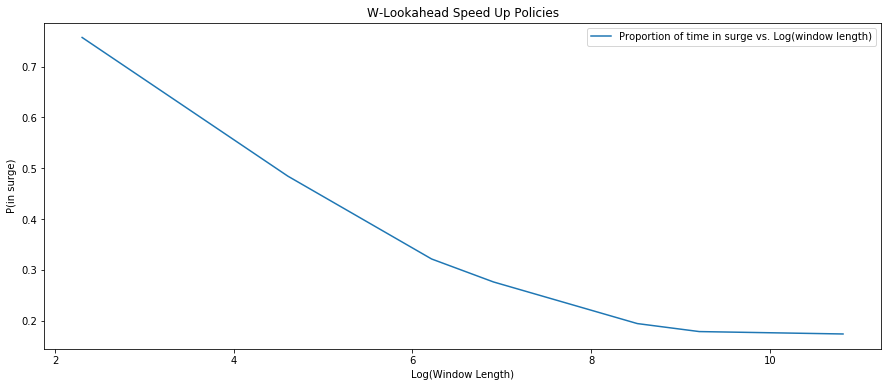

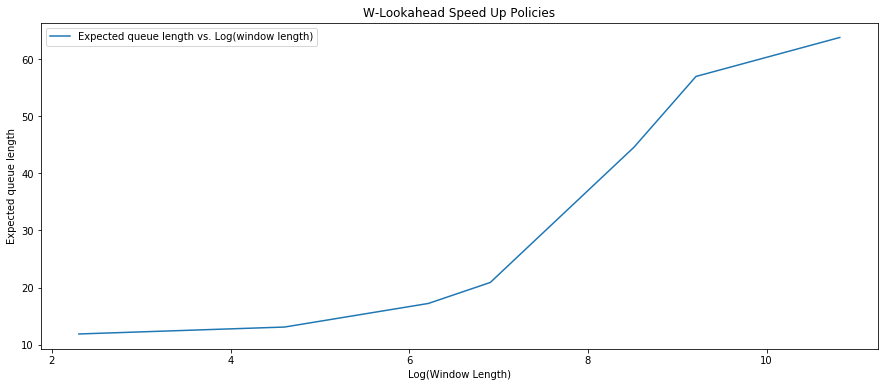

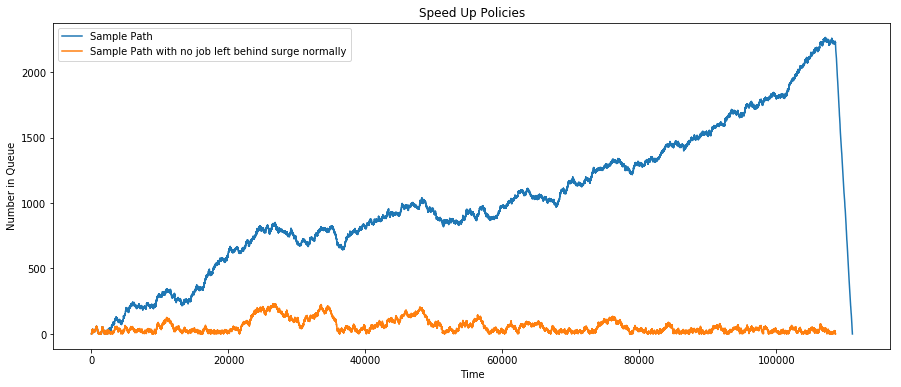

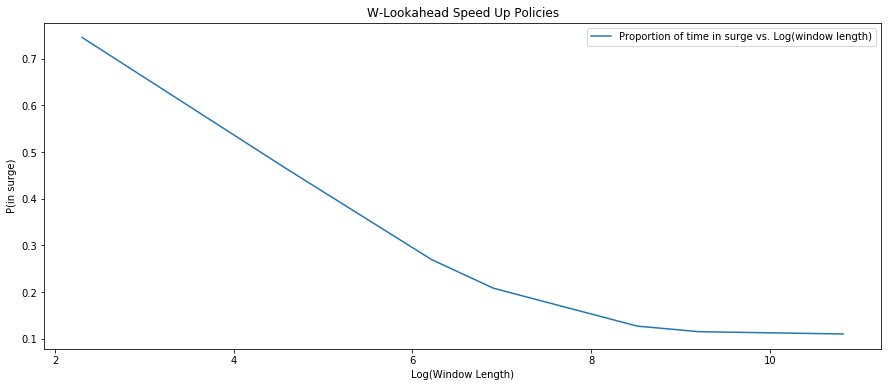

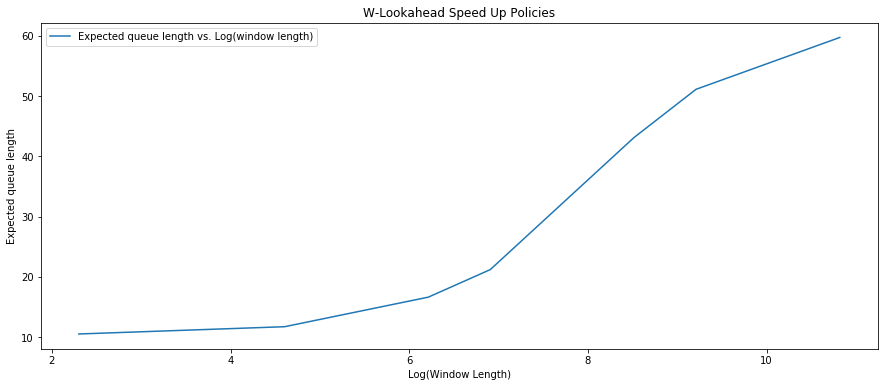

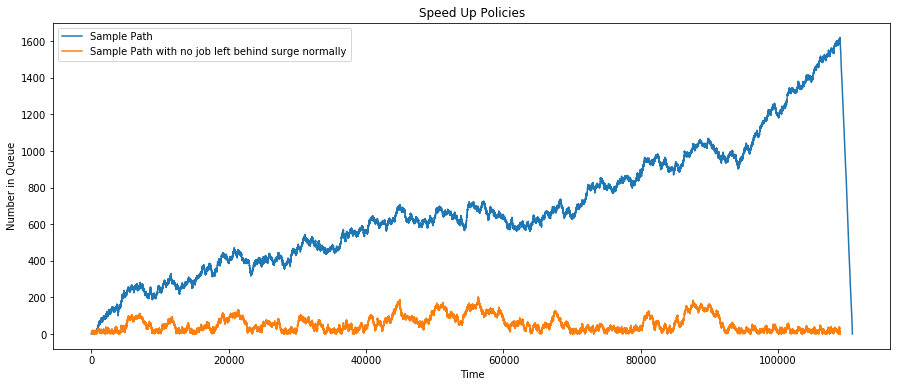

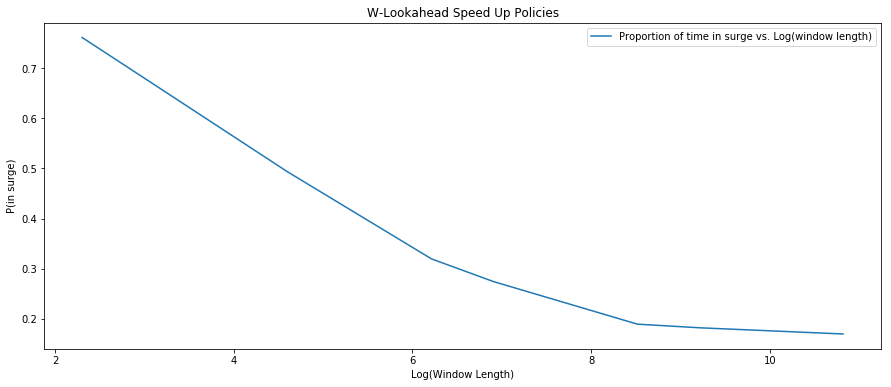

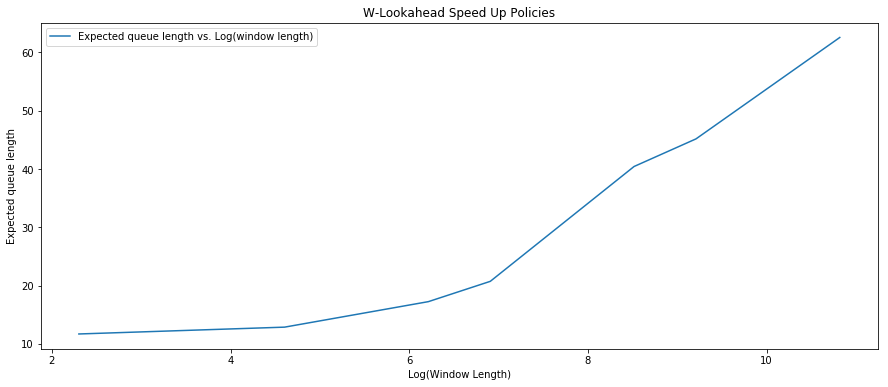

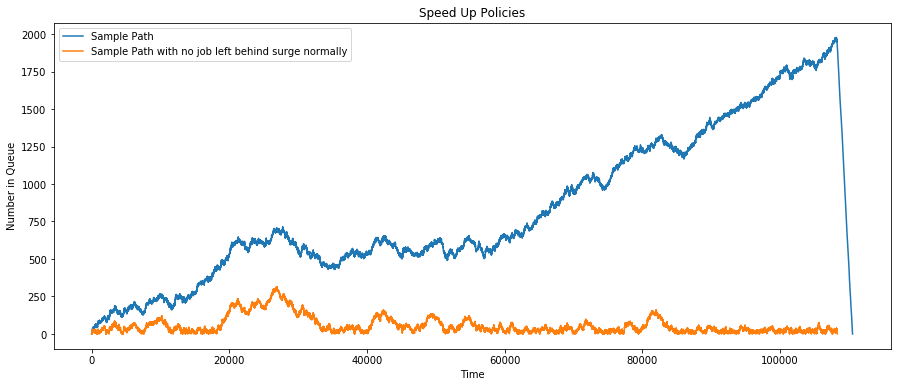

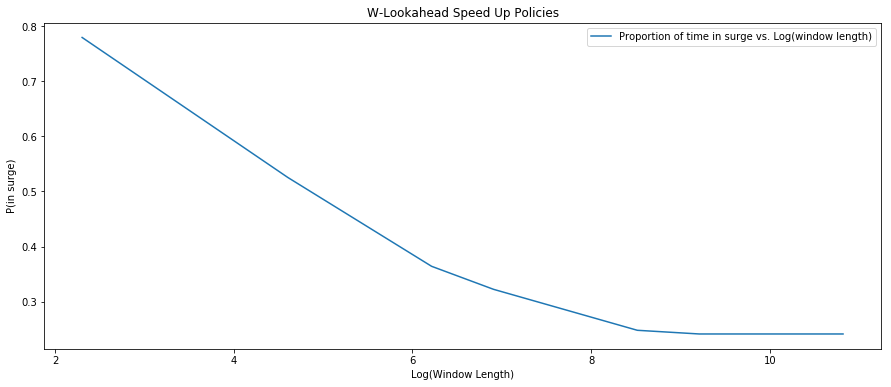

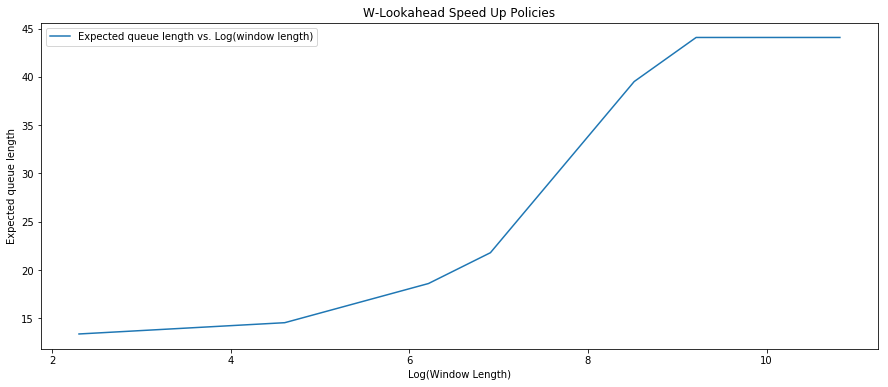

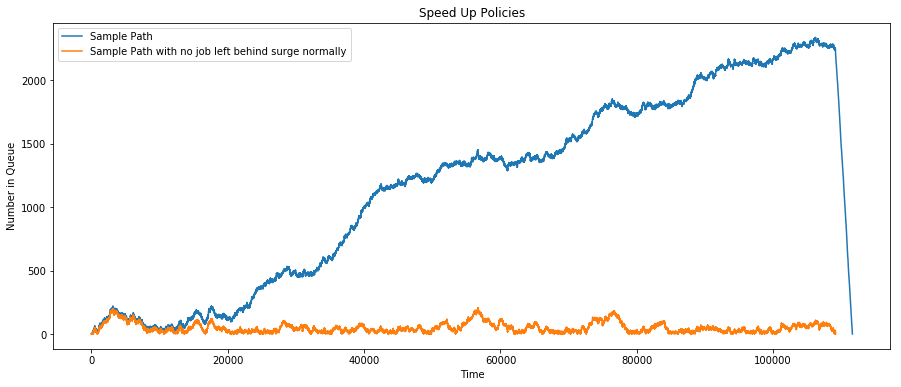

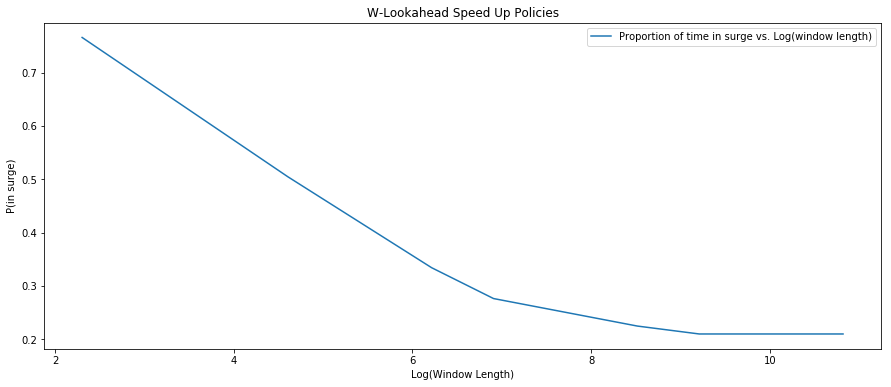

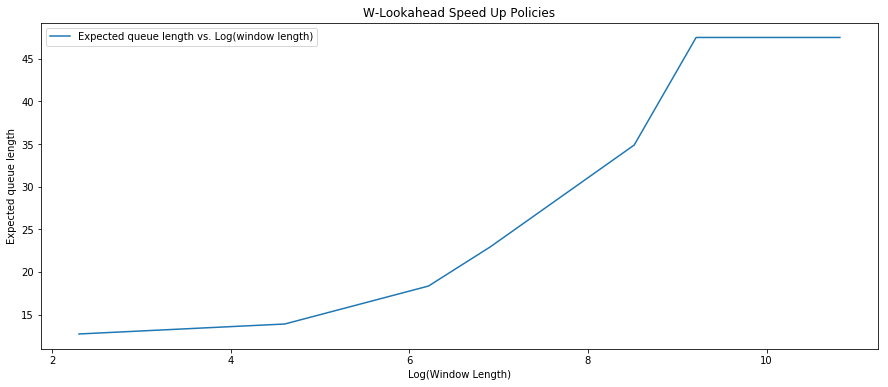

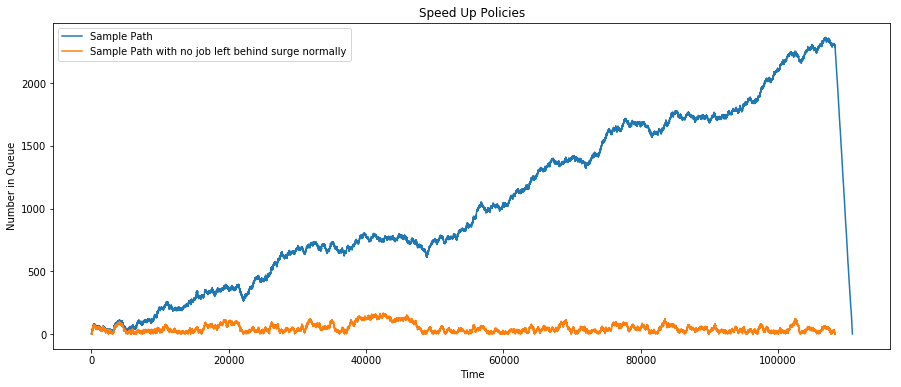

In [14]:
#  Task 1: For the NJLB speed up code with an infinite window, using Tmax = 10^5,
#  report expected queue length, p(speed up), and sample paths for a couple runs.

#  Task 2: For the NJLB speed up code with a finite lookahead window (looking ahead 
#  number of jobs instead of a time window), plot log(window lookahead size) vs.
#  proportion of jobs that get sped up and log(window lookahead size) vs. expected
#  waiting time.

print("k = %.2f" % (k))
print("g = %.2f" % (g))
print("\n")

Ts_task1 = list()
Ns_task1 = list()
Ts_pred_task1 = list()
Ns_pred_task1 = list()

Ts_task2 = list()
Ns_task2 = list()
ws_task2 = list()
in_surges_task2 = list()

# 100000 window corresponds to infinite lookahead
windows = [10, 100, 500, 1000, 5000, 10000, 50000]
log_windows = [math.log(i) for i in windows]

for i in range(5):
    print("Trial %d" % (i + 1))
    
    interarrivals, services = gen_interarrivals_and_services(lambd, mu1, n)

    arrival_times = []
    for i in range(len(interarrivals)):
        arrival_times.append(sum(interarrivals[0:i + 1]))

    service_times = [arrival_times[0] + services[0]]
    for i in range(1, len(services)):
        service_times.append(max(arrival_times[i], service_times[i - 1]) + services[i])

    T, N = generate_T_N(interarrivals.copy(), services.copy())
    
    
    # TASK 2
    Ts = list()
    Ns = list()
    ws = list()
    in_surges = list()
    
    for window in windows:
        print("\n")
        T_njlb1, N_njlb1, w1, in_surge_1 = implement_speedup(interarrivals.copy(), services.copy(), window)
        Ts.append(T_njlb1)
        Ns.append(N_njlb1)
        ws.append(w1)
        in_surges.append(in_surge_1)
        print("NJLB policy with %d lookahead, speed up" % (window))
        print("NJLB speed up for %.2f proportion of time" % (in_surge_1))
        print("NJLB Expected waiting time %.2f" % (mid80(w1)))
        
    Ts_task2.append(Ts)
    Ns_task2.append(Ns)
    ws_task2.append(ws)
    in_surges_task2.append(in_surges)
    
    figure(figsize=(15,6))
    plot(log_windows, in_surges, label='Proportion of time in surge vs. Log(window length)')
    xlabel('Log(Window Length)')
    ylabel('P(in surge)')
    title("W-Lookahead Speed Up Policies")
    legend()
    
    Ns_for_plot = [mid80(N) for N in Ns]
    figure(figsize=(15,6))
    plot(log_windows, Ns_for_plot, label='Expected queue length vs. Log(window length)')
    xlabel('Log(Window Length)')
    ylabel('Expected queue length')
    title("W-Lookahead Speed Up Policies")
    legend()

    # TASK 1
    print("\n")
    T_njlb3, N_njlb3, w3, in_surge_23 = implement_speedup(interarrivals.copy(), services.copy(), 100000)
    print("NJLB policy with infinite lookahead, surge all of time when lookahead conditions are not met")
    print("NJLB speed up for %.2f proportion of time" % (in_surge_23))
    print("NJLB Expected waiting time %.2f" % (mid80(w3)))

    figure(figsize=(15,6))
    plot(T, N, label='Sample Path')
    plot(T_njlb3, N_njlb3, label='Sample Path with no job left behind surge normally')
    xlabel('Time')
    ylabel('Number in Queue')
    title("Speed Up Policies")
    legend()
    print("\n\n")
    
    Ts_task1.append(T)
    Ns_task1.append(N)
    Ts_pred_task1.append(T_njlb3)
    Ns_pred_task1.append(N_njlb3)

NJLB Expected Queue Length 63.830



NJLB Expected Queue Length 59.733



NJLB Expected Queue Length 62.579



NJLB Expected Queue Length 44.079



NJLB Expected Queue Length 47.503





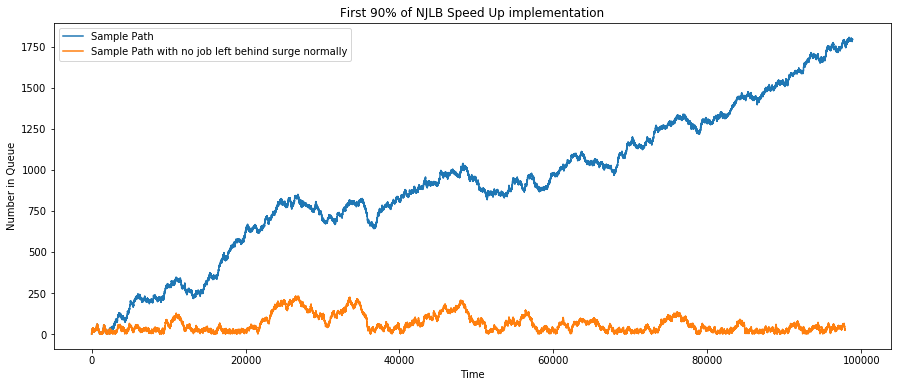

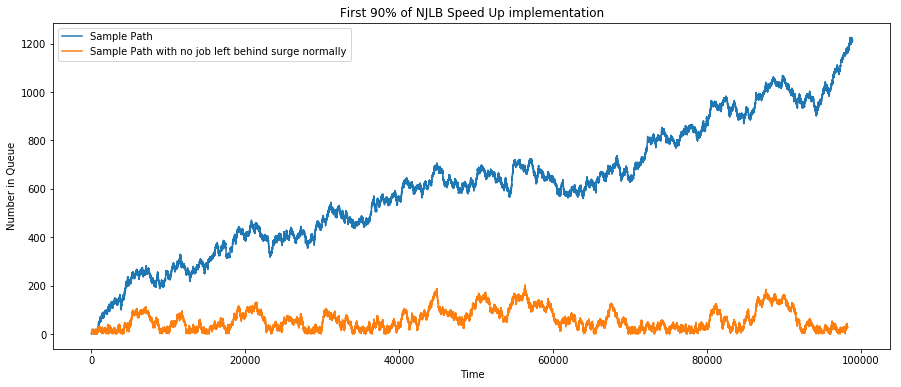

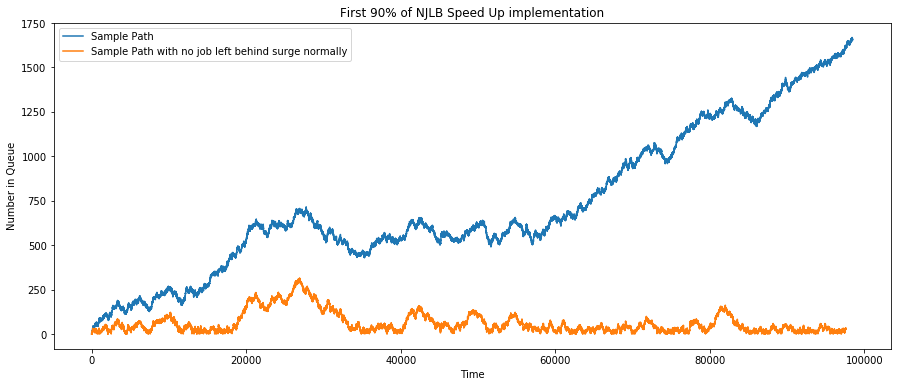

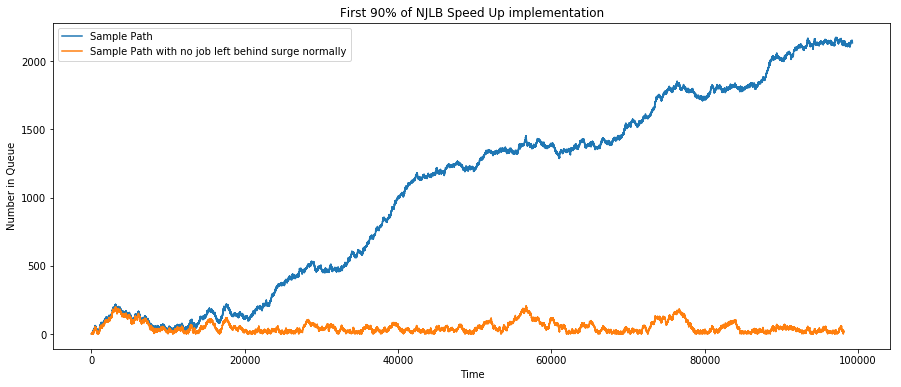

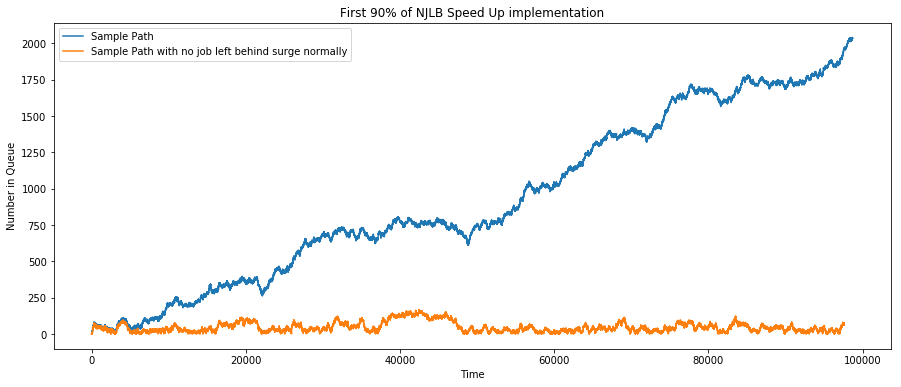

In [28]:
for i in range(5):
    T = Ts_task1[i]
    N = Ns_task1[i]
    T_njlb3 = Ts_pred_task1[i]
    N_njlb3 = Ns_pred_task1[i]
    
    print("NJLB Expected Queue Length %.3f" % (mid80(N_njlb3)))
    
    figure(figsize=(15,6))
    plot(first90(T), first90(N), label='Sample Path')
    plot(first90(T_njlb3), first90(N_njlb3), label='Sample Path with no job left behind surge normally')
    xlabel('Time')
    ylabel('Number in Queue')
    title("First 90% of NJLB Speed Up implementation")
    legend()
    print("\n\n")

In [17]:

'''T_threshold, N_threshold, S, in_surge = implement_threshold(interarrivals.copy(), services.copy(), threshold)
print("Threshold policy with threshold %d" % (threshold))
print("Threshold speed up for %.2f proportion of time" % (in_surge))
print("Threshold avg queue length %.2f" % (np.mean(N_threshold[start:end])))
print("Threshold average Q %.2f" % (S))'''
'''print("\n")
T_njlb, N_njlb, w, in_surge_2 = implement_speedup(interarrivals.copy(), services.copy(), 10000, .4)
print("NJLB policy with infinite lookahead, surge 0.4 of time when lookahead conditions are not met")
print("NJLB speed up for %.2f proportion of time" % (in_surge_2))
print("NJLB avg queue length %.2f" % (np.mean(N_njlb[start:end])))
print("NJLB Expected waiting time %.2f" % (np.mean(w)))'''


'''print("\n")

T_njlb2, N_njlb2, w2, in_surge_22 = implement_speedup_2(interarrivals.copy(), services.copy(), 10000)
print("NJLB policy with infinite lookahead, surge last 10% of jobs")
print("NJLB speed up for %.2f proportion of time" % (in_surge_22))
print("NJLB Expected waiting time %.2f" % (np.mean(w2)))
'''


#plot(T_threshold[:180000], N_threshold[:18000], label='Sample Path with threshold %d' % (threshold))
#plot(T_njlb[:18000], N_njlb[:18000], label='Sample Path with no job left behind, surge 40%')
#plot(T_njlb2[:18000], N_njlb2[:18000], label='Sample Path with no job left behind surge normally and last 10%')

'print("\n")\n\nT_njlb2, N_njlb2, w2, in_surge_22 = implement_speedup_2(interarrivals.copy(), services.copy(), 10000)\nprint("NJLB policy with infinite lookahead, surge last 10% of jobs")\nprint("NJLB speed up for %.2f proportion of time" % (in_surge_22))\nprint("NJLB Expected waiting time %.2f" % (np.mean(w2)))\n'